# Demonstrate the "target-decoy" approach, as applied to metagenomic variant calling

In [1]:
%run "Header.ipynb"

In [2]:
import copy
import json
import pickle
import skbio
import pileup
from collections import defaultdict
from pysam import VariantFile
from parse_sco import parse_sco

In [3]:
seq2pos2pileup = pileup.load()

In [7]:
# Positions with mutation frequency of at least this are considered high-frequency
# This is a percentage, so it's 5%
HIGH_FREQUENCY = 0.05

## First: naive variant calling (call a position as "$p$-mutated" if $freq(pos) > p$)

We don't limit to "sufficiently-covered" positions here -- so we consider all regions throughout a genome.

In [4]:
# Percentages go from 50%, 49.99%, 49.98%, ..., 0.02%, 0.01%
percentages = [p / 100 for p in range(1, 5001, 1)][::-1]
print(f"First two percentages: {percentages[:2]}")
print(f"Last two percentages: {percentages[-2:]}")
print(f"Number of percentages: {len(percentages):,}")
p2pct = get_p2pct(percentages)

First two percentages: [50.0, 49.99]
Last two percentages: [0.02, 0.01]
Number of percentages: 5,000


In [9]:
def compute_num_mutations_per_mb(num_called_mutations_in_positions, num_positions_considered):
    # We have the equation
    #
    #      # called mutations              f
    # ---------------------------- = --------------
    #  # of positions to consider     1,000,000 bp
    #
    # This function just solves for f by multiplying the left side of the equation by 1,000,000.
    #
    # I guess if you're gonna be calling this thousands of time on the same set of positions
    # it might speed this up slightly to precompute the (1,000,000 / # of positions to consider) value,
    # but convenience is the most important thing here IMO.
    return (num_called_mutations_in_positions / num_positions_considered) * 1000000
    

def naive_calling(seq, positions_to_consider, verbose=True, superverbose=False):
    """seq should be in SEQS.
    
    positions_to_consider should be a collection of 1-indexed positions in the sequence to consider when
    calling mutations. This makes it possible to, for example, just consider the CP 2 positions in a sequence.
    
    Returns a tuple with three elements:
    
    1. p2called_mutations: A dict mapping values in "percentages" (defined above) to a list of 1-indexed
       "called" p-mutations in the positions to consider in the sequence, using this percentage for p.
       
    2. p2numpermb: A dict with the same keys as p2called_mutations, but the values are the number of called
       p-mutations per megabase (1,000,000 bp = 1 Mbp) in the positions to consider in this sequence.
       IT'S DEFINITELY WORTH NOTING that we scale this by the number of positions to consider, not the full
       sequence length (although it's possible that those values could be equal if positions_to_consider
       is equal to range(1, seq2len[seq] + 1)). So, if you select a subset of positions where most of them
       are mutations, this'll result in a really high number of mutations per megabase!
       ...I recognize "numpermb" doesn't really roll off the tongue, but I couldn't think
       of a better name for this :P
       
    3. poslen: Length of positions_to_consider, for reference.
    
    NOTE THAT this'll not include "high-frequency" mutations in the results, as discussed in the paper.
    We will not decrease poslen or anything -- positions with high-frequency mutations will just be
    treated as if they were non-mutated positions.
    """
    poslen = len(positions_to_consider)
    seqlen = seq2len[seq]
    positions_to_consider_pct = 100 * (poslen / seqlen)
    if verbose:
        print(f"Naively calling mutations in {seq2name[seq]}.")
        print(f"\tConsidering {poslen:,} / {seqlen:,} ({positions_to_consider_pct:.2f}%) positions.")
    p2called_mutations = {p: [] for p in percentages}
    p2numpermb = {}
    for pi, pos in enumerate(sorted(positions_to_consider), 1):
        if verbose and (pi == 1 or pi % 100000 == 0):
            print(f"\tOn the {pi:,}-th position ({pos:,}) of the specified {poslen:,} positions ({100 * (pi / poslen):.2f}%).")
        pos_pileup = seq2pos2pileup[seq][pos]
        mfa_pct = pileup.get_alt_nt_pct(pos_pileup)
        for p in percentages:
            # Only include non-high-frequency ("rare") mutations
            if mfa_pct > p2pct[p] and mfa_pct < HIGH_FREQUENCY:
                p2called_mutations[p].append(pos)

    for p in p2called_mutations:
        num_called_mutations = len(p2called_mutations[p])
        p2numpermb[p] = compute_num_mutations_per_mb(num_called_mutations, poslen)
        # We add an extra layer of verbosity here because printing out 2 lines per value of p gets
        # ridiculous when there are 1,000 values of p .____.
        if superverbose:
            print(f"\tp = {p}%: {num_called_mutations:,} called p-mutations in {seq2name[seq]}.")
            print(f"\t\tNumber of called p-mutations per megabase: f = {f:,.2f}.")
        
    return (p2called_mutations, p2numpermb, poslen)


def naive_calling_fullseq(seq):
    """Does naive variant calling across all positions in a sequence (should be in SEQS)."""
    return naive_calling(seq, range(1, seq2len[seq] + 1))


def get_single_gene_cp2_positions(seq):
    cp2_positions = set()
    multi_gene_positions = set()
    
    seqlen = seq2len[seq]
    genes_df = parse_sco(f"../seqs/genes/{seq}.sco")
    
    # Code here is adapted from get_parent_gene_info_of_many_positions (in Header.ipynb) a bit
    # Faster to compute everything at once, rather than iterate through the genes multiple times
    pos_to_genes = defaultdict(list)
    
    for gene in genes_df.itertuples():
        gene_left = int(gene.LeftEnd)
        gene_right = int(gene.RightEnd)
        gene_num = int(gene.Index)
        gene_strand = gene.Strand
        
        def complainAboutCPs(gn, gs, gcp):
            raise ValueError(f"CP got out of whack: gene {gn}, strand {gs}, cp {gcp}?")
        
        if gene_strand == "+":
            cp = 1
        else:
            cp = 3
        
        for pos in range(gene_left, gene_right + 1):
            pos_to_genes[pos].append(gene_num)
            if len(pos_to_genes[pos]) > 1:
                multi_gene_positions.add(pos)
                
            if cp == 2:
                cp2_positions.add(pos)
                
            # Adjust the CP. I already have some code that does this (in a different context) in the within-
            # gene mutation spectrum notebook; ideally this code would be generalized between the notebooks.
            if gene_strand == "+":
                # For + strand genes, this goes 123123123123...
                if cp == 1 or cp == 2: cp += 1
                elif cp == 3: cp = 1
                else: complainAboutCPs(gene_num, gene_strand, cp)
            else:
                # For - strand genes, this goes 321321321321...
                if cp == 3 or cp == 2: cp -= 1
                elif cp == 1: cp = 3
                else: complainAboutCPs(gene_num, gene_strand, cp)
    
    single_gene_cp2_positions = cp2_positions - multi_gene_positions
    return single_gene_cp2_positions
    

def naive_calling_cp2seq(seq):
    """Does naive variant calling across just the CP 2 positions in a sequence (should be in SEQS).
    
    NOTE that this will filter only to positions that meet the exact criteria:
    
    - In a single gene (not in a position that is covered by overlapping genes).
    - In CP 2 within this single gene.
    
    Even if a position is in CP 2 of all the multiple genes it's covered by, we'll still ignore it.
    I'm pretty sure there should be very few positions that get tossed out as a result; my take is that
    it isn't worth the trouble to try to handle these positions.
    """

    print(f"Identifying CP 2 positions in {seq2name[seq]} so we can use them as a decoy genome...")
    single_gene_cp2_positions = get_single_gene_cp2_positions(seq)
    print(f"In {seq2name[seq]}:")
    #print(f"\tThere were {len(cp2_positions):,} CP 2 positions.")
    #print(f"\tThere were {len(multi_gene_positions):,} positions in multiple genes.")
    print(f"\tThere were {len(single_gene_cp2_positions):,} CP 2 positions in only a single gene.")
    return naive_calling(seq, single_gene_cp2_positions)

### Naively call mutations in CAMP and compute $\mathrm{frac}_{\mathrm{decoy}}$

(We're treating CAMP as a "decoy" genome, where we assume that all called mutations within it will be incorrect.)

In [10]:
camp_naive_p2called_mutations, camp_naive_p2numpermb, _ = naive_calling_fullseq("edge_6104")

Naively calling mutations in CAMP.
	Considering 1,289,244 / 1,289,244 (100.00%) positions.
	On the 1-th position (1) of the specified 1,289,244 positions (0.00%).
	On the 100,000-th position (100,000) of the specified 1,289,244 positions (7.76%).
	On the 200,000-th position (200,000) of the specified 1,289,244 positions (15.51%).
	On the 300,000-th position (300,000) of the specified 1,289,244 positions (23.27%).
	On the 400,000-th position (400,000) of the specified 1,289,244 positions (31.03%).
	On the 500,000-th position (500,000) of the specified 1,289,244 positions (38.78%).
	On the 600,000-th position (600,000) of the specified 1,289,244 positions (46.54%).
	On the 700,000-th position (700,000) of the specified 1,289,244 positions (54.30%).
	On the 800,000-th position (800,000) of the specified 1,289,244 positions (62.05%).
	On the 900,000-th position (900,000) of the specified 1,289,244 positions (69.81%).
	On the 1,000,000-th position (1,000,000) of the specified 1,289,244 posi

In [11]:
camp_cp2_naive_p2called_mutations, camp_cp2_naive_p2numpermb, num_camp_cp2_pos = naive_calling_cp2seq("edge_6104")

Identifying CP 2 positions in CAMP so we can use them as a decoy genome...
In CAMP:
	There were 394,850 CP 2 positions in only a single gene.
Naively calling mutations in CAMP.
	Considering 394,850 / 1,289,244 (30.63%) positions.
	On the 1-th position (267) of the specified 394,850 positions (0.00%).
	On the 100,000-th position (325,447) of the specified 394,850 positions (25.33%).
	On the 200,000-th position (651,427) of the specified 394,850 positions (50.65%).
	On the 300,000-th position (977,868) of the specified 394,850 positions (75.98%).


### For comparison, naively call mutations in BACT1 and compute $\mathrm{frac}_{\mathrm{BACT1}}$

In [12]:
bact1_naive_p2called_mutations, bact1_naive_p2numpermb, _ = naive_calling_fullseq("edge_1671")

Naively calling mutations in BACT1.
	Considering 2,153,394 / 2,153,394 (100.00%) positions.
	On the 1-th position (1) of the specified 2,153,394 positions (0.00%).
	On the 100,000-th position (100,000) of the specified 2,153,394 positions (4.64%).
	On the 200,000-th position (200,000) of the specified 2,153,394 positions (9.29%).
	On the 300,000-th position (300,000) of the specified 2,153,394 positions (13.93%).
	On the 400,000-th position (400,000) of the specified 2,153,394 positions (18.58%).
	On the 500,000-th position (500,000) of the specified 2,153,394 positions (23.22%).
	On the 600,000-th position (600,000) of the specified 2,153,394 positions (27.86%).
	On the 700,000-th position (700,000) of the specified 2,153,394 positions (32.51%).
	On the 800,000-th position (800,000) of the specified 2,153,394 positions (37.15%).
	On the 900,000-th position (900,000) of the specified 2,153,394 positions (41.79%).
	On the 1,000,000-th position (1,000,000) of the specified 2,153,394 posi

### Just so we can update the `misc-text/` file, also do this for  BACT2

probs possible to get this info from another notebook but this is the easiest way to handle this imo

In [13]:
bact2_naive_p2called_mutations, bact2_naive_p2numpermb, _ = naive_calling_fullseq("edge_2358")

Naively calling mutations in BACT2.
	Considering 2,806,161 / 2,806,161 (100.00%) positions.
	On the 1-th position (1) of the specified 2,806,161 positions (0.00%).
	On the 100,000-th position (100,000) of the specified 2,806,161 positions (3.56%).
	On the 200,000-th position (200,000) of the specified 2,806,161 positions (7.13%).
	On the 300,000-th position (300,000) of the specified 2,806,161 positions (10.69%).
	On the 400,000-th position (400,000) of the specified 2,806,161 positions (14.25%).
	On the 500,000-th position (500,000) of the specified 2,806,161 positions (17.82%).
	On the 600,000-th position (600,000) of the specified 2,806,161 positions (21.38%).
	On the 700,000-th position (700,000) of the specified 2,806,161 positions (24.95%).
	On the 800,000-th position (800,000) of the specified 2,806,161 positions (28.51%).
	On the 900,000-th position (900,000) of the specified 2,806,161 positions (32.07%).
	On the 1,000,000-th position (1,000,000) of the specified 2,806,161 posi

### Save this info to text files using the json module

... Since recomputing this takes, like, an hour

In [14]:
with open("misc-output/p2called_mutations.txt", "w") as p2cmf:
    for p2cm in (
        camp_naive_p2called_mutations, camp_cp2_naive_p2called_mutations,
        bact1_naive_p2called_mutations, bact2_naive_p2called_mutations
    ):
        p2cmf.write(json.dumps(p2cm))
        p2cmf.write("\n")

In [15]:
with open("misc-output/p2numpermb.txt", "w") as p2nf:
    for p2n in (
        camp_naive_p2numpermb, camp_cp2_naive_p2numpermb,
        bact1_naive_p2numpermb, bact2_naive_p2numpermb
    ):
        p2nf.write(json.dumps(p2n))
        p2nf.write("\n")

### Load naive calling info from text files

In [16]:
with open("misc-output/p2called_mutations.txt", "r") as p2cmf:
    camp_naive_p2called_mutations = json.loads(p2cmf.readline().strip())
    camp_cp2_naive_p2called_mutations = json.loads(p2cmf.readline().strip())
    bact1_naive_p2called_mutations = json.loads(p2cmf.readline().strip())
    bact2_naive_p2called_mutations = json.loads(p2cmf.readline().strip())
    
with open("misc-output/p2numpermb.txt", "r") as p2nf:
    camp_naive_p2numpermb = json.loads(p2nf.readline().strip())
    camp_cp2_naive_p2numpermb = json.loads(p2nf.readline().strip())
    bact1_naive_p2numpermb = json.loads(p2nf.readline().strip())
    bact2_naive_p2numpermb = json.loads(p2nf.readline().strip())

In [17]:
# If we haven't done naive calling yet, we gotta compute this number also so we can use this in figures, etc.
# And knowing the CP 2 positions anyway is needed for the LoFreq stuff.
camp_cp2_pos = get_single_gene_cp2_positions("edge_6104")
num_camp_cp2_pos = len(camp_cp2_pos)
print(f"There are {num_camp_cp2_pos:,} CP 2 single-gene positions in CAMP.")

There are 394,850 CP 2 single-gene positions in CAMP.


### Output info about FDR estimation for $p=0.5\%$ to `misc-text/`

**NOTE: this only includes "rare" (i.e. not high-frequency, as defined above) mutations.**

In [18]:
# Total numbers of identified p-mutations
camp_nump = len(camp_naive_p2called_mutations["0.5"])
bact1_nump = len(bact1_naive_p2called_mutations["0.5"])
bact2_nump = len(bact2_naive_p2called_mutations["0.5"])
# Scaled numbers of identified p-mutations per megabase (comparable across different-length genomes
# [at least, if you assume that genome length is the only confounding factor here, which it isn't -- we
# should mention this in the paper ofc])
camp_numpermb = camp_naive_p2numpermb["0.5"]
bact1_numpermb = bact1_naive_p2numpermb["0.5"]
bact2_numpermb = bact2_naive_p2numpermb["0.5"]

bact1_fdr = camp_numpermb / bact1_numpermb

naiveinfo = (
    f"At $p=0.5$\\%, we identified {camp_nump:,}, {bact1_nump:,}, and {bact2_nump:,} rare $p$-mutations "
    f"in the {seq2name['edge_6104']}, {seq2name['edge_1671']}, and {seq2name['edge_2358']} genomes, "
    f"respectively. This illustrates that there exists a difference of nearly two orders of magnitude "
    f"in the number of rare $p$-mutations per megabase across these genomes "
    f"({round(camp_numpermb):,}, {round(bact1_numpermb):,}, and {round(bact2_numpermb):,} for "
    f"{seq2name['edge_6104']}, {seq2name['edge_1671']}, and {seq2name['edge_2358']}, respectively). "
    f"If the {seq2name['edge_6104']} genome, which has a relatively low mutation rate, is "
    f"selected as a decoy, then we estimate the FDR for the {seq2name['edge_1671']} genome at $p=0.5\\%$ as "
    "$\\frac{" + f"{camp_numpermb:,.2f}" + "}" + "{" + f"{bact1_numpermb:,.2f}" + "}" + f" \\approx {bact1_fdr:.4f}$."
)
with open("misc-text/naive-calling-target-decoy.tex", "w") as of:
    # see https://tex.stackexchange.com/a/18018
    of.write("{}\endinput".format(naiveinfo))

print("-" * 79)
print("RESULTS that we're gonna output to a TeX file:")
print("-" * 79)
print(naiveinfo)

-------------------------------------------------------------------------------
RESULTS that we're gonna output to a TeX file:
-------------------------------------------------------------------------------
At $p=0.5$\%, we identified 248, 17,097, and 1,632 rare $p$-mutations in the CAMP, BACT1, and BACT2 genomes, respectively. This illustrates that there exists a difference of nearly two orders of magnitude in the number of rare $p$-mutations per megabase across these genomes (192, 7,940, and 582 for CAMP, BACT1, and BACT2, respectively). If the CAMP genome, which has a relatively low mutation rate, is selected as a decoy, then we estimate the FDR for the BACT1 genome at $p=0.5\%$ as $\frac{192.36}{7,939.56} \approx 0.0242$.


In [19]:
bact1_fdr_using_camp = camp_naive_p2numpermb["0.5"] / bact1_naive_p2numpermb["0.5"]
bact1_fdr_using_campcp2 = camp_cp2_naive_p2numpermb["0.5"] / bact1_naive_p2numpermb["0.5"]
cp2info = (
    "For example, at the frequency threshold $p=0.5$\%, there are only "
    f"{len(camp_cp2_naive_p2called_mutations['0.5']):,} rare $p$-mutations in CP2 in the {seq2name['edge_6104']} "
    f"genome, resulting in {round(camp_cp2_naive_p2numpermb['0.5']):,} mutations per megabase of the CP2 "
    f"positions (as compared to {round(camp_naive_p2numpermb['0.5']):,} for the entire {seq2name['edge_6104']} genome). "
    f"Therefore, the estimate of the FDR for called mutations in the {seq2name['edge_1671']} genome "
    f"can now be reduced from {bact1_fdr_using_camp:,.4f} to {bact1_fdr_using_campcp2:,.4f}."
)

with open("misc-text/camp-cp2-fdr.tex", "w") as of:
    of.write("{}\endinput".format(cp2info))
    
print("-" * 79)
print("RESULTS that we're gonna output to a TeX file:")
print("-" * 79)
print(cp2info)

-------------------------------------------------------------------------------
RESULTS that we're gonna output to a TeX file:
-------------------------------------------------------------------------------
For example, at the frequency threshold $p=0.5$\%, there are only 52 rare $p$-mutations in CP2 in the CAMP genome, resulting in 132 mutations per megabase of the CP2 positions (as compared to 192 for the entire CAMP genome). Therefore, the estimate of the FDR for called mutations in the BACT1 genome can now be reduced from 0.0242 to 0.0166.


### Load LoFreq calls, and output info about FDR estimation for LoFreq to `misc-text/`

#### Load LoFreq VCF info and compute various things

**NOTE: this still only includes "rare" (i.e. not high-frequency, as defined above) mutations.** LoFreq can call either type of mutations, but we explicitly filter out high-frequency mutations here to make its calls comparable with the naive ones above.

In [22]:
# Load LoFreq info
lofreq_calls = VariantFile("../seqs/lofreq.vcf")

# Record raw numbers of called mutations from LoFreq
camp_lofreq_mutations = set()
camp_cp2_lofreq_mutations = set()
bact1_lofreq_mutations = set()
bact2_lofreq_mutations = set()

# (and these things, which we'll use to plot an FDR curve)
# NOTE: this code is gross and duplicated because it's 7pm on a friday, should make better
bact1_lofreq_p2num_called_mutations_i = {p: 0 for p in percentages}
bact1_lofreq_p2numpermb = {}
camp_lofreq_p2num_called_mutations_i = {p: 0 for p in percentages}
camp_lofreq_p2numpermb = {}
camp_cp2_lofreq_p2num_called_mutations_i = {p: 0 for p in percentages}
camp_cp2_lofreq_p2numpermb = {}

total_bact1_called_variants = 0

for c in lofreq_calls.fetch():
    
    alt_pct = pileup.get_alt_nt_pct(seq2pos2pileup[c.contig][c.pos])
    
    if alt_pct < HIGH_FREQUENCY:
        if c.contig == "edge_6104":
            camp_lofreq_mutations.add(c.pos)
            if c.pos in camp_cp2_pos:
                camp_cp2_lofreq_mutations.add(c.pos)

        elif c.contig == "edge_1671":
            bact1_lofreq_mutations.add(c.pos)
            total_bact1_called_variants += 1

        elif c.contig == "edge_2358":
            bact2_lofreq_mutations.add(c.pos)

print(f"According to LoFreq, there are {len(camp_lofreq_mutations):,} rare mutations in CAMP.")
print(f"... and {len(camp_cp2_lofreq_mutations):,} rare mutations in CAMP CP 2.")
print(f"... and {len(bact1_lofreq_mutations):,} rare mutations in BACT1.")
print(f"... and {len(bact2_lofreq_mutations):,} rare mutations in BACT2.")

if total_bact1_called_variants != len(bact1_lofreq_mutations):
    print("-" * 79)
    print(
        f"NOTE: There were actually {total_bact1_called_variants:,} variants total in BACT1 -- due to some\n"
        "variants being called at the same position. The code accounts for this, don't worry."
    )
    print("-" * 79)

print("Being slow and assigning p2num_called_mutations_i for BACT1 and CAMP based on LoFreq...")
# NOTE: iterating lazily over all percentages is a very terrible, slow way to do this.
# Possible to make it much faster if we sort the percentages in advance, probs...
# if this is a bottleneck for you please go send marcus an angry email, sorry 2021 is a rough year
for p in percentages:
    # consider each UNIQUE position with a called variant -- positions with > 1 called variant will
    # only get one pass in this loop. this is intentional.
    #
    # so basically, if you're me in a year and you're like "what is this code even doing", the idea is
    # that a given point in the FDR curve only includes variants with mutation frequency > that point,
    # since we're adjusting "p" to create this FDR curve. This is exactly the same as how the naive
    # mutation calling works, so we can reuse that on the LoFreq calls, if this isn't too convoluted.
    # (we could also use the reported AF [allele frequency] from LoFreq instead of the pileup thing, but
    # i figure we may as well be consistent since we're collapsing things to single positions anyway)
    for pos in bact1_lofreq_mutations:
        if pileup.naively_call_mutation(seq2pos2pileup["edge_1671"][pos], p2pct[p]):
            bact1_lofreq_p2num_called_mutations_i[p] += 1
            
    # same as above
    for pos in camp_lofreq_mutations:
        if pileup.naively_call_mutation(seq2pos2pileup["edge_6104"][pos], p2pct[p]):
            camp_lofreq_p2num_called_mutations_i[p] += 1
            
    for pos in camp_cp2_lofreq_mutations:
        if pileup.naively_call_mutation(seq2pos2pileup["edge_6104"][pos], p2pct[p]):
            camp_cp2_lofreq_p2num_called_mutations_i[p] += 1
        
print("Phew, done with that.")

# Compute numbers of mutations per megabase
camp_lofreq_numpermb = compute_num_mutations_per_mb(len(camp_lofreq_mutations), seq2len["edge_6104"])
camp_cp2_lofreq_numpermb = compute_num_mutations_per_mb(len(camp_cp2_lofreq_mutations), num_camp_cp2_pos)
bact1_lofreq_numpermb = compute_num_mutations_per_mb(len(bact1_lofreq_mutations), seq2len["edge_1671"])
bact2_lofreq_numpermb = compute_num_mutations_per_mb(len(bact2_lofreq_mutations), seq2len["edge_2358"])

# Create p2num_called_mutations for BACT1 using LoFreq.
for p in percentages:
    bact1_num_called_mutations = bact1_lofreq_p2num_called_mutations_i[p]
    bact1_lofreq_p2numpermb[str(p)] = compute_num_mutations_per_mb(bact1_num_called_mutations, seq2len["edge_1671"])
    
    camp_num_called_mutations = camp_lofreq_p2num_called_mutations_i[p]
    camp_lofreq_p2numpermb[str(p)] = compute_num_mutations_per_mb(camp_num_called_mutations, seq2len["edge_6104"])
    
    camp_cp2_num_called_mutations = camp_cp2_lofreq_p2num_called_mutations_i[p]
    camp_cp2_lofreq_p2numpermb[str(p)] = compute_num_mutations_per_mb(camp_cp2_num_called_mutations, num_camp_cp2_pos)

# Compute FDRs!
bact1_fdr_lofreq_camp_decoy = camp_lofreq_numpermb / bact1_lofreq_numpermb
bact1_fdr_lofreq_camp_cp2_decoy = camp_cp2_lofreq_numpermb / bact1_lofreq_numpermb
print(
    "Just using the LoFreq calls, the FDR for BACT1 using CAMP as a decoy is "
    f"{bact1_fdr_lofreq_camp_decoy:.4f}."
)
print(
    "Just using the LoFreq calls, the FDR for BACT1 using CAMP CP 2 as a decoy is "
    f"{bact1_fdr_lofreq_camp_cp2_decoy:.4f}."
)

According to LoFreq, there are 22 rare mutations in CAMP.
... and 4 rare mutations in CAMP CP 2.
... and 9,641 rare mutations in BACT1.
... and 79 rare mutations in BACT2.
-------------------------------------------------------------------------------
NOTE: There were actually 9,674 variants total in BACT1 -- due to some
variants being called at the same position. The code accounts for this, don't worry.
-------------------------------------------------------------------------------
Being slow and assigning p2num_called_mutations_i for BACT1 and CAMP based on LoFreq...
Phew, done with that.
Just using the LoFreq calls, the FDR for BACT1 using CAMP as a decoy is 0.0038.
Just using the LoFreq calls, the FDR for BACT1 using CAMP CP 2 as a decoy is 0.0023.


#### Compute naïve mutation calling info for $p = 2\%$ mutations

Because it turns out these are pretty similar to what LoFreq calls.

In [23]:
nc2 = camp_naive_p2called_mutations["2.0"]
nb12 = bact1_naive_p2called_mutations["2.0"]
nb22 = bact2_naive_p2called_mutations["2.0"]

fdr_num_n2 = camp_naive_p2numpermb["2.0"]
fdr_den_n2 = bact1_naive_p2numpermb["2.0"]
fdr_n2 = fdr_num_n2 / fdr_den_n2
print(f"Estimated FDR at p = 2% is {fdr_num_n2:,.2f} / {fdr_den_n2:,.2f} = {fdr_n2:,.4f}")

seq2naive2ct = {}
seq2overlapct = {}
for seq, naive_2pct_muts, lf_muts in (
    ("edge_6104", nc2, camp_lofreq_mutations),
    ("edge_1671", nb12, bact1_lofreq_mutations),
    ("edge_2358", nb22, bact2_lofreq_mutations)
):
    # Print out info to prove to myself that yes, p=2% and LoFreq are pretty similar!
    nl = len(naive_2pct_muts)
    ll = len(lf_muts)
    print(f"{seq2name[seq]} has {nl:,} p = 2% p-mutations and {ll:,} LoFreq-called mutations.")
    naive_lf_overlap = set(naive_2pct_muts) & set(lf_muts)
    ol = len(naive_lf_overlap)
    print(f"\tNumber of overlapping calls btwn (naive calling at p=2%) and (LoFreq): {ol:,}")
    print(f"\tPercentage of (Overlap / LoFreq): {100 * (ol / ll):.2f}%")
    
    # ... Save this info to dicts to make it easy to output in the misc text notebook below.
    # I guess we could do that here instead but, uh, whatever, no reason to make this more complicated
    # than it already is. I don't think we have enough coffee for that.
    seq2naive2ct[seq] = nl
    seq2overlapct[seq] = ol

Estimated FDR at p = 2% is 13.19 / 4,888.10 = 0.0027
CAMP has 17 p = 2% p-mutations and 22 LoFreq-called mutations.
	Number of overlapping calls btwn (naive calling at p=2%) and (LoFreq): 15
	Percentage of (Overlap / LoFreq): 68.18%
BACT1 has 10,526 p = 2% p-mutations and 9,641 LoFreq-called mutations.
	Number of overlapping calls btwn (naive calling at p=2%) and (LoFreq): 8,026
	Percentage of (Overlap / LoFreq): 83.25%
BACT2 has 100 p = 2% p-mutations and 79 LoFreq-called mutations.
	Number of overlapping calls btwn (naive calling at p=2%) and (LoFreq): 43
	Percentage of (Overlap / LoFreq): 54.43%


In [24]:
# Output info -- analogous to the naive info output above.
# ... BUT WITH MORE STUFF since we're comparing LoFreq to the naive method at p=2%
lf_camp_num = len(camp_lofreq_mutations)
lf_bact1_num = len(bact1_lofreq_mutations)
lf_bact2_num = len(bact2_lofreq_mutations)

# Just because we use this a lot...!
seqnames = f"{seq2name['edge_6104']}, {seq2name['edge_1671']}, and {seq2name['edge_2358']}"

lfinfo = (
    f"LoFreq called {lf_camp_num:,}, {lf_bact1_num:,}, and {lf_bact2_num:,} rare mutations "
    f"in the {seqnames} genomes, "
    f"respectively. At the frequency threshold $p = 2\%$, the "
    r'na\"ive method called a similar number of rare $p$-mutations '
    f"({seq2naive2ct['edge_6104']:,}, {seq2naive2ct['edge_1671']:,}, and {seq2naive2ct['edge_2358']:,} for "
    f"{seqnames}, respectively). It turns out that the sets of rare mutations identified by LoFreq and by "
    r'the na\"ive method at $p = 2\%$ are similar: the numbers of overlapping rare mutations between these '
    f"groups are {seq2overlapct['edge_6104']:,}, {seq2overlapct['edge_1671']:,}, and "
    f"{seq2overlapct['edge_2358']:,} for {seqnames}. This suggests that, at least for this dataset, "
    f"LoFreq primarily detected rare mutations with frequency of at least 2\%. Here, we describe an analysis of "
    f"FDRs which suggests that there exist many more lower-frequency rare mutations.\n\n"
)
lfinfo += (
    f"Using LoFreq's calls, the numbers of rare mutations per megabase for each genome are "
    f"{round(camp_lofreq_numpermb):,}, {round(bact1_lofreq_numpermb):,}, and {round(bact2_lofreq_numpermb):,} "
    f"for {seq2name['edge_6104']}, {seq2name['edge_1671']}, and {seq2name['edge_2358']}, respectively. "
    f"We can evaluate the FDR of LoFreq's calls in the same way as earlier: using the "
    f"{seq2name['edge_1671']} genome as a target and the {seq2name['edge_6104']} genome as a decoy, we "
    f"estimate the FDR for {seq2name['edge_1671']} as "
    "$\\frac{"
    f"{camp_lofreq_numpermb:,.2f}"
    "}{"
    f"{bact1_lofreq_numpermb:,.2f}"
    "}"
    f" \\approx {bact1_fdr_lofreq_camp_decoy:,.4f}$. "
)
lfinfo += (
    r'This is similar to the FDR of the na\"ive approach at the frequency threshold of $p = 2\%$, which '
    f"had an estimated FDR (using {seq2name['edge_1671']} as a target and {seq2name['edge_6104']} as a decoy) of "
    "$\\frac{"
    f"{fdr_num_n2:,.2f}"
    "}{"
    f"{fdr_den_n2:,.2f}"
    "}"
    f" \\approx {fdr_n2:,.4f}$. "
    r'Although both LoFreq and the na\"ive approach at $p = 2\%$ result in the reliable identification of '
    "rare mutations with low FDR, we are still interested in extending the set of identified rare mutations while "
    r'controlling the FDR. For example, lowering the frequency threshold of the na\"ive approach to '
    f"$p = 0.5\%$ results in the identification of {len(bact1_naive_p2called_mutations['0.5']):,} rare mutations in the "
    f"{seq2name['edge_1671']} genome (an additional "
    f"{len(bact1_naive_p2called_mutations['0.5']) - seq2naive2ct['edge_1671']:,} rare mutations as compared to $p = 2\%$) "
    "with a slightly higher but still relatively low FDR (still using CAMP as a decoy) of "
    f"{camp_naive_p2numpermb['0.5'] / bact1_naive_p2numpermb['0.5']:,.4f}."
)

with open("misc-text/lofreq-target-decoy.tex", "w") as of:
    # see https://tex.stackexchange.com/a/18018
    of.write("{}\endinput".format(lfinfo))

print("-" * 79)
print("RESULTS that we're gonna output to a TeX file:")
print("-" * 79)
print(lfinfo)

-------------------------------------------------------------------------------
RESULTS that we're gonna output to a TeX file:
-------------------------------------------------------------------------------
LoFreq called 22, 9,641, and 79 rare mutations in the CAMP, BACT1, and BACT2 genomes, respectively. At the frequency threshold $p = 2\%$, the na\"ive method called a similar number of rare $p$-mutations (17, 10,526, and 100 for CAMP, BACT1, and BACT2, respectively). It turns out that the sets of rare mutations identified by LoFreq and by the na\"ive method at $p = 2\%$ are roughly similar: the numbers of overlapping rare mutations between these groups are 15, 8,026, and 43 for CAMP, BACT1, and BACT2. This suggests that, at least for this dataset, LoFreq primarily detected rare mutations with frequency of at least 2\%. Here, we describe an analysis of FDRs which suggests that there exist many more lower-frequency rare mutations.

Using LoFreq's calls, the numbers of rare mutations pe

## Plot estimated BACT1 FDR vs. scaled number of identified (rare) mutations

Previous versions of this notebook only drew one FDR curve at a time; now, this function accepts multiple decoy genome `p2numpermb` objects.

In [28]:
def plot_bact1_fdr(
    target_p2numpermb, decoy_p2numpermbs, colors, shapes, decoy_labels, fig_basename,
    use_log=True, start_p=None, end_p=None, show_p_labels=False,
    special_p_markers=[50, 25, 13, 10, 5, 2, 0.22, 0.15, 0.13, 0.08, 0.06, 0.01],
    titleprefix=f"{seq2name['edge_1671']} FDR curves based on na\u00efve rare $p$-mutation calling"
):
    """Plots FDR curves with some fancy annotations.
    
    target_p2numpermb is analogous to bact1_naive_p2numpermb. This maps values of p (some percentage
    that you're using as a cutoff for calling mutations) to the number of called mutations per megabase
    for some genome. (This is currently assumed to be BACT1, because of e.g. the title we use for this
    figure, but really you could draw these sorta curves for any genome that you have variant calls for.)
    
    decoy_p2numpermbs, colors, shapes, and decoy_labels should all be collections of identical length
    (this lets you pass in and style multiple decoy genomes to be shown on the same plot). So, for example,
    you can show how different decoy genomes result in different FDR curves for the same target genome.
    """
    
    fig, ax = pyplot.subplots(1)
    
    for di, decoy_p2numpermb in enumerate(decoy_p2numpermbs):
        if start_p is None:
            start_p = percentages[0]
        
        if end_p is None:
            end_p = percentages[-1]
        
        # This is all the percentages we HOPE to use
        attempting_to_use_percentages = percentages[percentages.index(start_p) : percentages.index(end_p) + 1]
        # This is all the percentages we CAN use (the FDR is d/t, so if t is 0 then we can't show that FDR...)
        used_percentages = []
        
        p2bact1fdr = {}
        for p in attempting_to_use_percentages:
            d = decoy_p2numpermb[str(p)]
            t = target_p2numpermb[str(p)]
            if t != 0:
                p2bact1fdr[p] = d / t
                used_percentages.append(p)
            
        # FDR
        x = []
        # number of mutations per megabase
        y = []
        # list of 2-tuples of (x,y). we'll highlight these points.
        special_xys = []
        for p in used_percentages:
            cx = p2bact1fdr[p]
            cy = target_p2numpermb[str(p)]
            x.append(cx)
            y.append(cy)
            if show_p_labels:
                # add labels (manually positioned). yeah, i know i know
                # we only show these labels once per plot (to avoid the text overlapping itself
                # from doing this multiple times), and we don't do this for non-log plots since
                # i tuned the adjusted coordinates to log plots
                dy = None
                dx = None
                if use_log:
                    if p == 50: dy = -20; dx = -0.01
                    elif p == 25: dy = 10; dx = -0.09
                    elif p == 13: dy = -5; dx = 0.02
                    elif p == 10: dy = 10; dx = 0.03
                    elif p == 5: dy = -100; dx = 0.03
                    elif p == 2: dy = -10**3; dx = 0.03
                    elif p == 0.22: dy = -10**3.3; dx = 0.03
                    elif p == 0.15: dy = -10**3; dx = 0.03
                    elif p == 0.13: dy = 15000; dx = -0.1
                    elif p == 0.08: dy = 0; dx=0.03
                    elif p == 0.06: dy = 53000; dx = -0.04
                    elif p == 0.01: dy = 53000; dx = -0.05
                else:
                    if p == 2: dy = -10**3.7; dx = 0.03
                    elif p == 0.22: dy = -10**3.9; dx = 0.03
                    elif p == 0.15: dy = -10**3; dx = 0.03
                    elif p == 0.13: dy = 10000; dx = -0.1
                    elif p == 0.08: dy = 0; dx=0.03
                    elif p == 0.06: dy = 5000; dx = -0.04
                    elif p == 0.01: dy = 5000; dx = -0.05
                    
                if dy is not None:
                    if p >= 1:
                        text = f"$p = {p:.0f}\%$"
                    elif p >= 0.5:
                        text = f"$p = {p:.1f}\%$"
                    else:
                        text = f"$p = {p:.2f}\%$"
                    if di == 0:
                        ax.text(cx + dx, cy + dy, text)
                        
            if p in special_p_markers:
                special_xys.append((cx, cy))

        ax.plot(x, y, marker=shapes[di], color=colors[di], label=decoy_labels[di])
        if len(special_xys) > 0:
            ax.scatter([xy[0] for xy in special_xys], [xy[1] for xy in special_xys], color="#ffff00", zorder=2000, s=20)
        
    ax.set_xlabel(f"Estimated FDR for called rare $p$-mutations in {seq2name['edge_1671']}")
    ax.set_ylabel("Number of called rare $p$-mutations per megabase")
    title = (
        f"{titleprefix},\nusing {len(used_percentages):,} values of $p$ from {max(used_percentages):.2f}% to {min(used_percentages):.2f}%"
    )
    if use_log:
        ax.set_yscale("symlog")
        title += " (log scale)"
    else:
        title += " (non-log scale)"
    ax.set_title(title, fontsize=20)
    ax.legend()
    use_thousands_sep(ax.yaxis)
    fig.set_size_inches(15, 8)
    fig.savefig(f"figs/{fig_basename}.png", bbox_inches="tight")

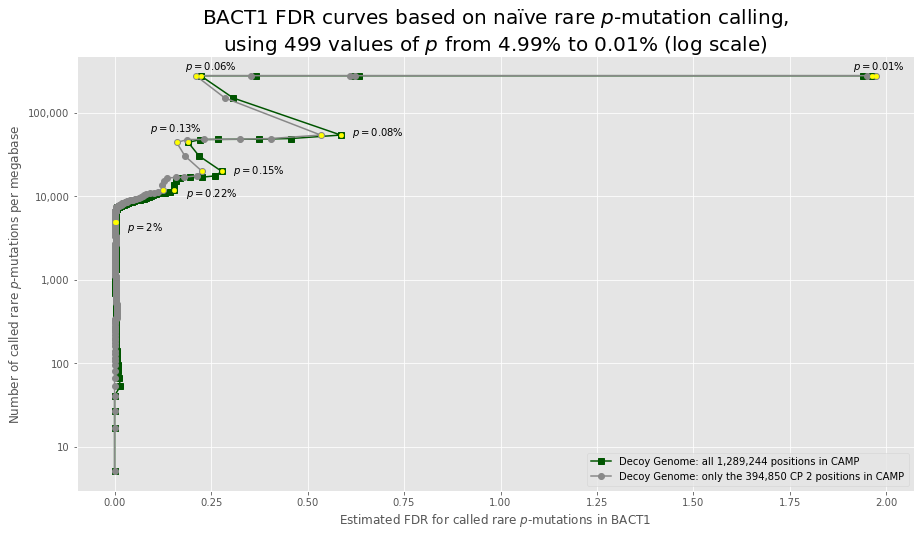

In [29]:
plot_bact1_fdr(
    bact1_naive_p2numpermb,
    (camp_naive_p2numpermb, camp_cp2_naive_p2numpermb),
    ("#005500", cp2color[2]),
    ("s", "o"),
    (
        f"Decoy Genome: all {seq2len['edge_6104']:,} positions in {seq2name['edge_6104']}",
        f"Decoy Genome: only the {num_camp_cp2_pos:,} CP 2 positions in {seq2name['edge_6104']}",
    ),
    "BACT1_FDR_CAMP_decoy",
    show_p_labels=True
)

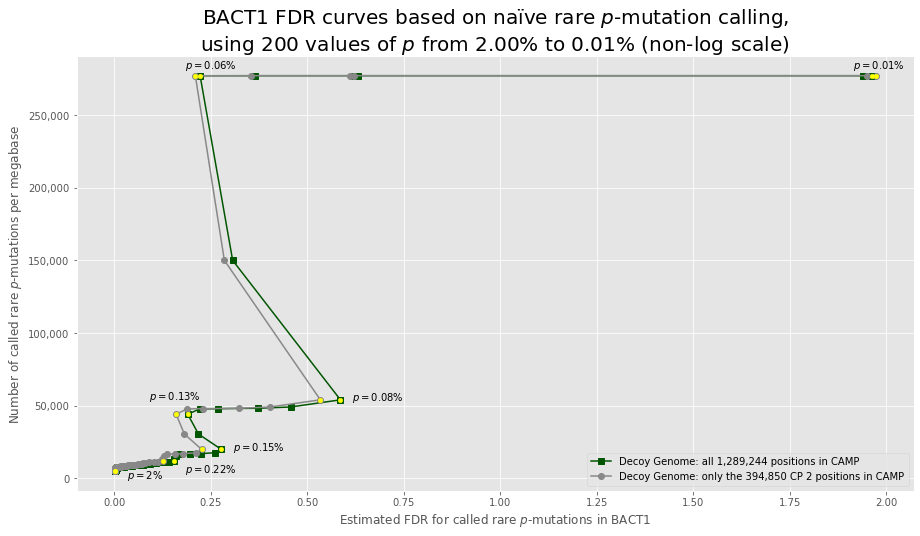

In [30]:
# plot_bact1_fdr(
#     (camp_naive_p2numpermb, camp_cp2_naive_p2numpermb),
#     ("#005500", cp2color[2]),
#     ("s", "o"),
#     (
#         f"Decoy Genome: all {seq2len['edge_6104']:,} positions in {seq2name['edge_6104']}",
#         f"Decoy Genome: only the {num_camp_cp2_pos:,} CP 2 positions in {seq2name['edge_6104']}",
#     ),
#     "BACT1_FDR_CAMP_decoy_max2",
#     start_p=2
# )
plot_bact1_fdr(
    bact1_naive_p2numpermb,
    (camp_naive_p2numpermb, camp_cp2_naive_p2numpermb),
    ("#005500", cp2color[2]),
    ("s", "o"),
    (
        f"Decoy Genome: all {seq2len['edge_6104']:,} positions in {seq2name['edge_6104']}",
        f"Decoy Genome: only the {num_camp_cp2_pos:,} CP 2 positions in {seq2name['edge_6104']}",
    ),
    "BACT1_FDR_CAMP_decoy_nonlog_max2",
    use_log=False,
    start_p=2,
    show_p_labels=True
)

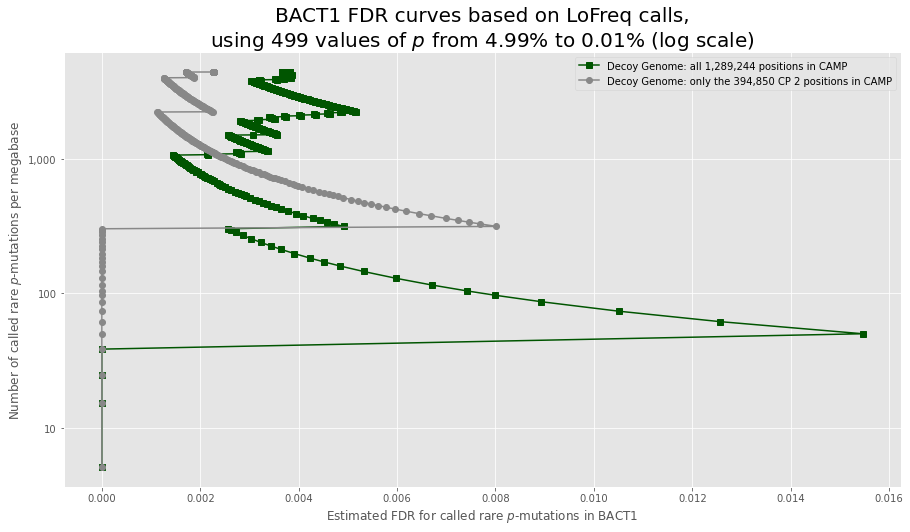

In [34]:
plot_bact1_fdr(
    bact1_lofreq_p2numpermb,
    (camp_lofreq_p2numpermb, camp_cp2_lofreq_p2numpermb),
    ("#005500", cp2color[2]),
    ("s", "o"),
    (
        f"Decoy Genome: all {seq2len['edge_6104']:,} positions in {seq2name['edge_6104']}",
        f"Decoy Genome: only the {num_camp_cp2_pos:,} CP 2 positions in {seq2name['edge_6104']}",
    ),
    "BACT1_FDR_CAMP_decoy_lofreq",
    titleprefix="BACT1 FDR curves based on LoFreq calls",
    special_p_markers=[]
)

## Show how adjusting $p$ adjusts the number of $p$-mutations in a genome (and the FDR, using the T/D approach)

In [35]:
# There is the possibility that we can't compute the FDR for certain values of p -- if a genome has 0 mutations
# for this value of p. In this case, we label these points with a color of None. In order to force matplotlib to
# draw a gray circle for these points, instead of just leaving them blank, we take the default viridis colormap
# and apply the set_bad() method to it to use this gray color. This, in conjunction with the "plotnonfinite"
# argument to scatter(), lets us draw gray circles for values of p with an undefined FDR (see
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html).
viridis_cmap = copy.copy(matplotlib.cm.get_cmap("viridis"))
viridis_cmap.set_bad("#888888")

In [55]:
from matplotlib.ticker import MultipleLocator

In [63]:
seq2p2called_mutations = {
    "edge_6104": camp_naive_p2called_mutations,
    "edge_1671": bact1_naive_p2called_mutations,
    "edge_2358": bact2_naive_p2called_mutations,
    "CAMP CP 2": camp_cp2_naive_p2called_mutations
}

seq2p2numpermb = {
    "edge_1671": bact1_naive_p2numpermb,
    "edge_2358": bact2_naive_p2numpermb,
}

def p_vs_num_muts_plot(leftmost_p=percentages[0], rightmost_p=percentages[-1],
                       fdr_vmin=0, fdr_vmax=1, ylogscale=False, fig_basename=None):
    
    fig, axes = pyplot.subplots(5, 1, gridspec_kw={"hspace": 0.6, "height_ratios": [1, 1, 1, 1, 0.2]})
    
    used_percentages = percentages[percentages.index(leftmost_p):percentages.index(rightmost_p) + 1]
    
    for si, seq in enumerate(["edge_6104", "edge_1671", "edge_2358", "CAMP CP 2"]):
        
        # Reuse the already-called p2called_mutations dicts to save time.
        p2called_mutations = seq2p2called_mutations[seq]
        y = [len(p2called_mutations[str(p)]) for p in used_percentages]
  
        # Two phases: 1) line plot, 2) scatter plot. This lets us color points by FDR.
        axes[si].plot(used_percentages, y, c="#888888")

        if seq != "edge_6104" and seq != "CAMP CP 2":
            fdrs = []
            for p in used_percentages:
                if seq2p2numpermb[seq][str(p)] > 0:
                    f = camp_naive_p2numpermb[str(p)] / seq2p2numpermb[seq][str(p)]
                else:
                    # draw a gray dot for this value of p since we can't compute the FDR (due to the
                    # denominator, i.e. the number of p-mutations per megabase in the "target" genome, being 0)
                    f = None
                fdrs.append(f)
            # https://stackoverflow.com/a/8204981
            sc = axes[si].scatter(used_percentages, y, c=fdrs, cmap=viridis_cmap, vmin=fdr_vmin, vmax=fdr_vmax, plotnonfinite=True)
        else:
            axes[si].scatter(used_percentages, y, c="#888888")

        if seq in SEQS:
            axes[si].set_title(seq2name[seq])
        else:
            axes[si].set_title(seq)
            
        # important to set y scale before calling use_thousands_sep() -- otherwise, the 10^n notation
        # will trump the thousands separator stuff
        if ylogscale:
            axes[si].set_yscale("symlog")
            # We use a huge upper bound here of max(y) * 5 because in order to make a visible difference for
            # log scales we gotta use really huge numbers (because of, uh, math). Since this is a log10 scale,
            # we can think of the 5 coefficient as getting us halfway to the next highest y-axis tick mark. Not
            # an ideal way to handle this for sure, but it works.
            axes[si].set_ylim(-0.5, max(y) * 5)
        else:
            # for some reason ylim doesn't seem to work with the non-log case... probably I'm doing something
            # wrong. in any case, this does work to give the y-axis some breathing room so that y=0 points aren't
            # only half shown on the plot. c/o https://stackoverflow.com/a/23609079
            axes[si].margins(0.1)
            
        use_thousands_sep(axes[si].yaxis)
        
        # alter the amount of padding used based on the number of percentages we have. Use less padding if
        # there are only a few percentage points shown.
        padding = 1e-4 * len(used_percentages)
        axes[si].set_xlim(leftmost_p + padding, rightmost_p - padding)
        if leftmost_p <= 1:
            axes[si].xaxis.set_major_locator(MultipleLocator(0.1))

    fig.text(0.05, 0.33, "Number of called rare $p$-mutations in a genome", rotation=90, fontsize=16, color="#6b6b6b")
    axes[-2].set_xlabel("Value of $p$ used to call $p$-mutations (%)", fontsize=16)

    num_p_vals = len(used_percentages)
    title = f"$p$ vs. number of called rare $p$-mutations: {num_p_vals:,} values of p $\in$ [{leftmost_p:.2f}%, {rightmost_p:.2f}%]"
    if ylogscale:
        title += "; log scale"
    fig.suptitle(title, x=0.52, y=0.95, fontsize=20)
    fig.set_size_inches(15, 13)
    
    fig.colorbar(sc, cax=axes[-1], orientation="horizontal")
    
    fdr_desc = ""
    if fdr_vmin != 0:
        fdr_desc = f"FDRs < {fdr_vmin} are clamped to {fdr_vmin}; "
    fdr_desc += f"FDRs > {fdr_vmax} are clamped to {fdr_vmax}"
    axes[-1].set_xlabel(f"Color scaling applied to BACT1 and BACT2 estimated FDRs (using all of CAMP as a decoy)\n{fdr_desc}", fontsize=14)
    
    if fig_basename is not None:
        fig.savefig(f"figs/{fig_basename}.png", bbox_inches="tight")

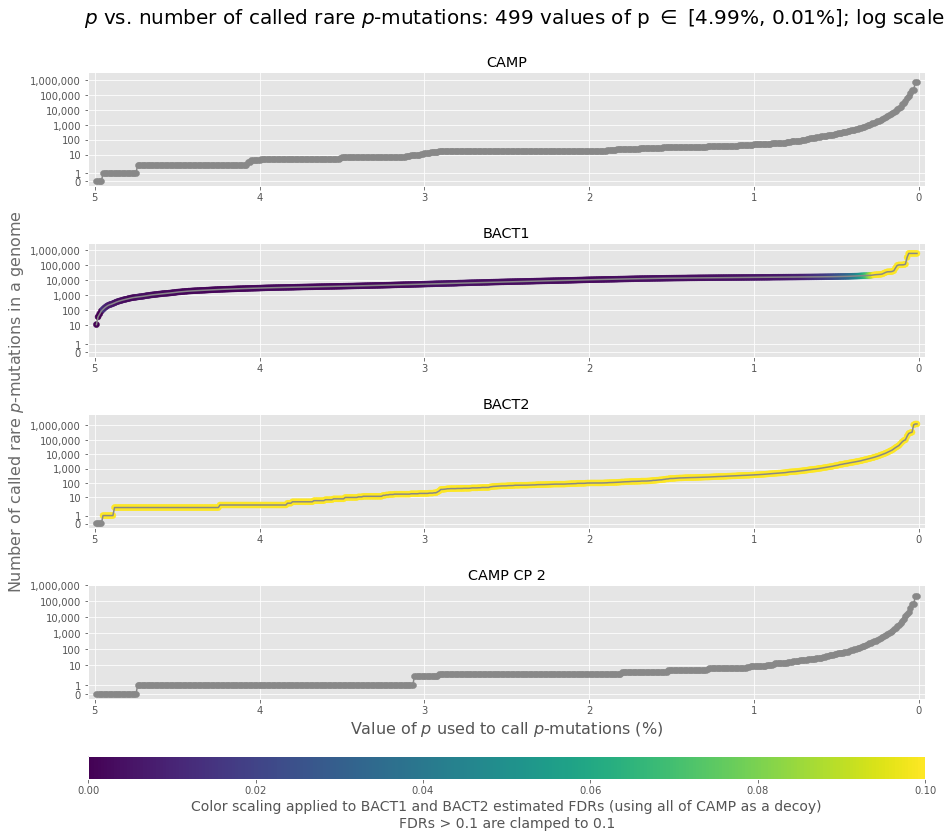

In [64]:
p_vs_num_muts_plot(
    leftmost_p=4.99,
    ylogscale=True, fig_basename="p_vs_num_muts_log_clamp",
    fdr_vmin=0, fdr_vmax=0.1,
)

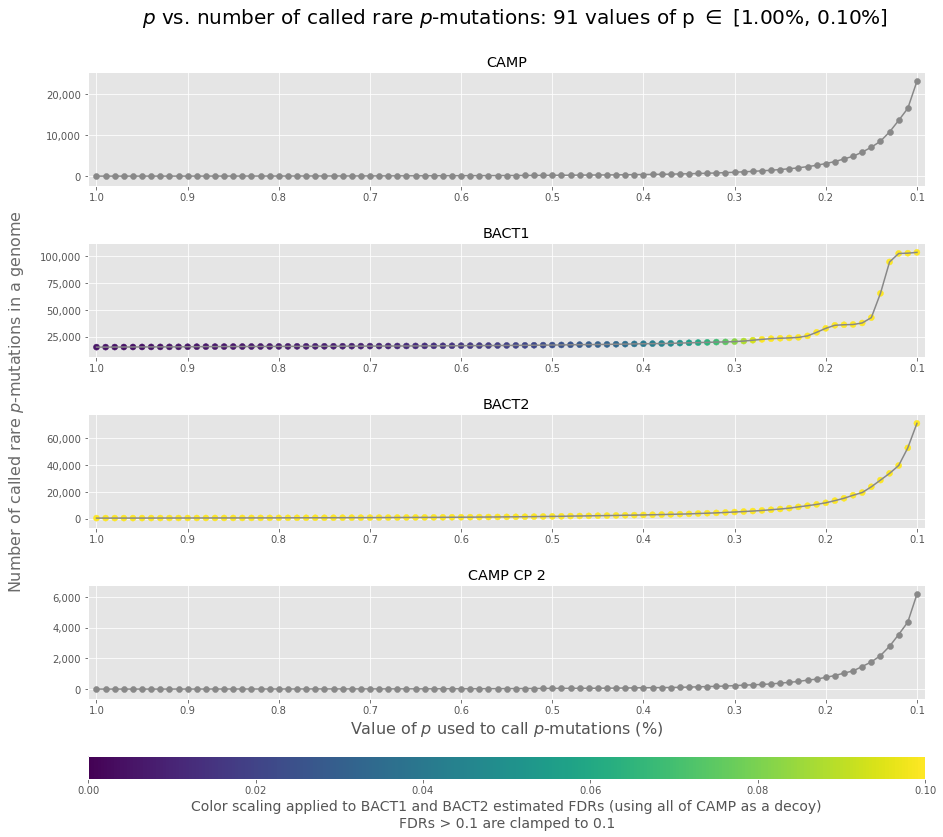

In [65]:
p_vs_num_muts_plot(
    leftmost_p=1, rightmost_p=0.1,
    ylogscale=False, fig_basename="p_vs_num_muts_nonlog_clamp",
    fdr_vmin=0, fdr_vmax=0.1,
)

## FDR curves using nonsynonymous mutation rates and nonsense mutation rates

### Load info about single-nucleotide codon mutations (syn vs nonsyn and non-nonsense vs nonsense) from files

In [59]:
def load_pf(basename):
    with open(f"misc-output/{basename}.pickle", "rb") as pf:
        return pickle.load(pf)

p2seq2obs_si = load_pf("p2seq2obs_si")
p2seq2obs_ni = load_pf("p2seq2obs_ni")
p2seq2obs_nnsi = load_pf("p2seq2obs_nnsi")
p2seq2obs_nsi = load_pf("p2seq2obs_nsi")

seq2poss_si = load_pf("seq2poss_si")
seq2poss_ni = load_pf("seq2poss_ni")
seq2poss_nnsi = load_pf("seq2poss_nnsi")
seq2poss_nsi = load_pf("seq2poss_nsi")

### Compute $R_S$, $R_N$, $R_{NNS}$, $R_{NS}$

In [60]:
# Rates for synonymous and nonsynonymous s.n. mutations
p2seq2synvals = {p: {} for p in percentages}
# Rates for non-nonsense and nonsense s.n. mutations
p2seq2nonsensevals = {p: {} for p in percentages}

for p in percentages:
    for seq in SEQS:
        p2seq2synvals[p][seq] = {}
        # R_S
        p2seq2synvals[p][seq]["syn"] = p2seq2obs_si[p][seq] / seq2poss_si[seq]
        # R_N
        p2seq2synvals[p][seq]["nonsyn"] = p2seq2obs_ni[p][seq] / seq2poss_ni[seq]

        p2seq2nonsensevals[p][seq] = {}
        # R_NNS
        p2seq2nonsensevals[p][seq]["nonnonsense"] = p2seq2obs_nnsi[p][seq] / seq2poss_nnsi[seq]
        # R_NS
        p2seq2nonsensevals[p][seq]["nonsense"] = p2seq2obs_nsi[p][seq] / seq2poss_nsi[seq]

### Plot (estimated) FDR curves using nonsynonymous and nonsense mutation rates

At p = 5.0%, R_N = 0.00011170233266261127 and R_NS = 8.856680095607861e-06. # p-muts per mb = 0.0
At p = 2.0%, R_N = 0.0002628887907108369 and R_NS = 1.3285020143411792e-05. # p-muts per mb = 4888.097579913383
At p = 0.15%, R_N = 0.000929328568818762 and R_NS = 0.0008048508036883644. # p-muts per mb = 19835.199689420515
At p = 0.1%, R_N = 0.002472548190048418 and R_NS = 0.0027610700198057512. # p-muts per mb = 48142.14212540761
At p = 0.06%, R_N = 0.016158442827385638 and R_NS = 0.018872478198728403. # p-muts per mb = 277164.7919516819


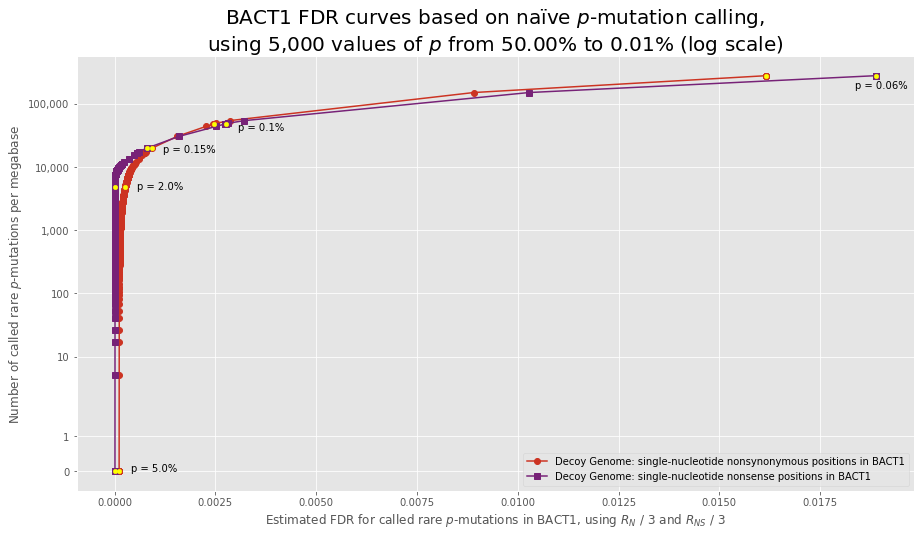

In [67]:
fig, ax = pyplot.subplots(1)

# Highlight the points at these values of p
special_p = [5, 2, 0.15, 0.1, 0.06]
special_xys = []

# x-axis: Estimated FDR (equal to R_N or R_NS divided by 3)
fdr_nonsyn = []
fdr_nonsense = []

# y-axis: Number of called p-mutations per megabase
num_called_pmuts_per_mb = []

for p in percentages:
    y = bact1_naive_p2numpermb[str(p)]
    x_n = p2seq2synvals[p]["edge_1671"]["nonsyn"] / 3
    x_ns = p2seq2nonsensevals[p]["edge_1671"]["nonsense"] / 3
    
    num_called_pmuts_per_mb.append(y)
    fdr_nonsyn.append(x_n)
    fdr_nonsense.append(x_ns)
    
    if p in special_p:
        print(f"At p = {p}%, R_N = {x_n} and R_NS = {x_ns}. # p-muts per mb = {y}")
        special_xys.append((x_n, y))
        special_xys.append((x_ns, y))
        dx = dy = 0
        if p == 50 or p == 10: dx = 0.0003
        if p == 5: dx = 0.0004
        if p == 2: dx = 0.00055; dy = -500
        if p == 0.15: dx = 0.0004; dy = -3000
        if p == 0.1: dx = 0.0003; dy = -10000
        if p == 0.06: dx = -0.0005; dy = -100000
        ax.text(x_ns + dx, y + dy, f"p = {p}%")
              
ax.plot(fdr_nonsyn, num_called_pmuts_per_mb, marker="o", color="#cc3322",
        label=f"Decoy Genome: single-nucleotide nonsynonymous positions in {seq2name['edge_1671']}")

# We darken the color representing nonsense (NS) mutations from the NNS / NS bar plot, in order to make it
# contrast better with the color representing nonsynonymous (N) mutations
ax.plot(fdr_nonsense, num_called_pmuts_per_mb, marker="s", color="#772277",
        label=f"Decoy Genome: single-nucleotide nonsense positions in {seq2name['edge_1671']}")
        
ax.scatter([xy[0] for xy in special_xys], [xy[1] for xy in special_xys], color="#ffff00", zorder=2000, s=20)
    
ax.set_xlabel(f"Estimated FDR for called rare $p$-mutations in {seq2name['edge_1671']}" + r", using $R_N\ /\ 3$ and $R_{NS}\ /\ 3$")
ax.set_ylabel("Number of called rare $p$-mutations per megabase")
title = (
    f'BACT1 FDR curves based on na\u00efve $p$-mutation calling,\nusing {len(percentages):,} values of $p$ from {max(percentages):.2f}% to {min(percentages):.2f}%'
)
ax.set_yscale("symlog")
title += " (log scale)"
ax.set_title(title, fontsize=20)
ax.legend()
use_thousands_sep(ax.yaxis)
fig.set_size_inches(15, 8)
fig.savefig(f"figs/bact1_fdr_nonsyn_nonsense.png", bbox_inches="tight")